# Taylor-series: FitzHugh-Nagumo

The FHN problem is a common non-stiff differential equation.

In [1]:
"""Benchmark all Taylor-series estimators on the Fitzhugh-Nagumo problem."""

import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.config import config

from probdiffeq.util.doc_util import notebook

config.update("jax_platform_name", "cpu")

In [2]:
def load_results():
    """Load the results from a file."""
    return jnp.load("./results.npy", allow_pickle=True)[()]


def choose_style(label):
    """Choose a plotting style for a given algorithm."""
    if "taylor" in label.lower():
        return {"color": "C0", "linestyle": "solid"}
    if "forward" in label.lower():
        return {"color": "C1", "linestyle": "dashed"}
    if "doubling" in label.lower():
        return {"color": "C2", "linestyle": "dotted"}
    msg = f"Label {label} unknown."
    raise ValueError(msg)


def plot_results(axis_compile, axis_perform, results):
    """Plot the results."""
    for label, wp in results.items():
        style = choose_style(label)

        inputs = wp["arguments"]
        work_mean = wp["work_compile"]
        axis_compile.semilogy(inputs, work_mean, label=label, **style)

        work_mean, work_std = (wp["work_mean"], wp["work_std"])
        range_lower, range_upper = work_mean - work_std, work_mean + work_std
        axis_perform.semilogy(inputs, work_mean, label=label, **style)
        axis_perform.fill_between(inputs, range_lower, range_upper, alpha=0.3, **style)

    return axis_compile, axis_perform

I0000 00:00:1696353251.833149  401501 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


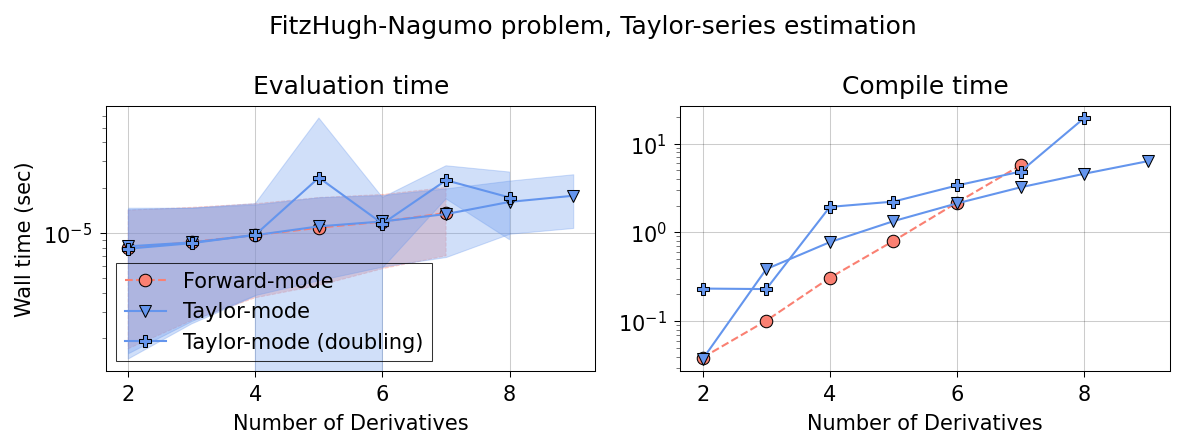

In [3]:
plt.rcParams.update(notebook.plot_config())

fig, (axis_perform, axis_compile) = plt.subplots(
    ncols=2, dpi=150, figsize=(8, 3), sharex=True, tight_layout=True
)
fig.suptitle("FitzHugh-Nagumo problem, Taylor-series estimation")

results = load_results()
axis_compile, axis_perform = plot_results(axis_compile, axis_perform, results)

axis_compile.set_title("Compile time")
axis_perform.set_title("Evaluation time")
axis_perform.legend()
axis_compile.set_xlabel("Number of Derivatives")
axis_perform.set_xlabel("Number of Derivatives")
axis_perform.set_ylabel("Wall time (sec)")
axis_perform.grid()
axis_compile.grid()

plt.show()